In [48]:
#Initial Setup
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from time import process_time

In [49]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number])# keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [50]:
df = pd.read_csv('dass_modeling.csv')
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,No Degree,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,No Degree,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,No Degree,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,Biology,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,Psychology,32,4,40,4,29,3


In [52]:
#df.drop('age_group',axis=1,inplace=True)

In [53]:
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,No Degree,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,No Degree,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,No Degree,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,Biology,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,Psychology,32,4,40,4,29,3


In [54]:
df.dtypes.value_counts()

int64     63
object     2
dtype: int64

In [56]:
df['country']=pd.factorize(df['country'], sort=True)[0]+1
df['major']=pd.factorize(df['major'], sort=True)[0]+1
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,46,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,46,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,46,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,10,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,56,32,4,40,4,29,3


In [9]:
df.dtypes.value_counts()

int64      21
object      3
float64     2
dtype: int64

# Target variable will determine severe depression. Levels 3 or 4 indicates severe depression.  So 1 means the individual has 
# severe depression, while 0 means they do not.

bin_out=[]

for i in df['Depression_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Depression_cat_bin']=bin_out

# Repeat same for Anxiety
bin_out=[]

for i in df['Anxiety_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Anxiety_cat_bin']=bin_out

# ...and for Stress
bin_out=[]

for i in df['Stress_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Stress_cat_bin']=bin_out

df.head()

In [ ]:
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [27]:
# Slice feature columns from dataframe for X
X = df.iloc[:,:17]

In [28]:
# Apply MinMaxScaler for PCA
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)

In [29]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
reduced_ninety_five = pca.transform(X_rescaled)
no_comp = reduced_ninety_five.shape[1]
no_comp

14

This shows that 14 components will be sufficient to capture 95% of the variance.

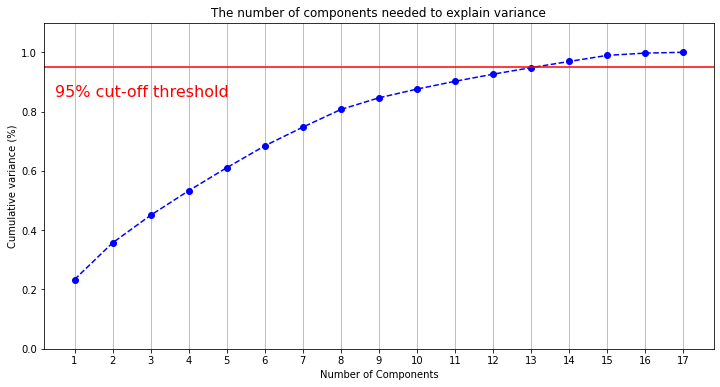

In [30]:
# Visualizing the PCA determination of number of components

pca = PCA().fit(X_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 18, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 18, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [31]:
# Three different output columns to examine
y = df['Depression_cat_bin']

# Check balance of dataset
y.value_counts()

1    20039
0    19698
Name: Depression_cat_bin, dtype: int64

The data looks very well-balanced, so I may not need to perform SMOTE-ENN after all.  To be thorough, I'll examine the value counts before and after SMOTE-ENN.

In [32]:
# Perform SMOTE-ENN on the dataset
resample=SMOTEENN(random_state=42)

X_res, y_res = resample.fit_resample(X,y)

print(y_res.value_counts())

0    3657
1    3542
Name: Depression_cat_bin, dtype: int64


In [35]:
# Create training and test sets to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# Apply Principal Component Analysis
pca = PCA(n_components = no_comp)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.951763,1.067320,0.222280,-0.242019,-0.291501,0.010329,1.093457,0.519767,-0.742758,2.229185,-1.944210,-0.537310,-0.030174,-0.545706
1,1.556803,3.097817,1.006464,1.274957,-1.457932,1.692502,1.812926,0.634090,-0.694147,0.437947,0.391161,1.437666,0.285829,-0.969310
2,-1.463845,0.321837,0.122485,0.055913,-1.114012,0.870046,0.825560,-1.058821,-1.272747,0.114265,-2.123575,0.451171,0.219074,-0.181859
3,2.422794,-0.252024,-0.039583,-2.251717,0.905359,-1.952696,0.737688,1.290923,1.154243,0.412880,-0.008063,-0.262390,-0.061023,-0.287701
4,-0.776384,1.397296,0.018599,0.883574,1.723770,-0.524870,0.349524,0.215586,-1.093623,-1.541751,1.422447,-0.322078,1.578188,0.369909


In [40]:
# Examine feature importance
dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': dtc.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)

print(importances)

    Attribute  Importance
1           1    0.205908
0           0    0.124758
12         12    0.069783
7           7    0.069415
13         13    0.068375
9           9    0.060762
3           3    0.058972
4           4    0.054326
5           5    0.051779
8           8    0.050692
11         11    0.048089
6           6    0.047239
10         10    0.046347
2           2    0.043554


In [41]:
t1_start = process_time() 

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_scaled,y_train)
y_pred=rfc.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  0.4281744192888376
Processing time =  0.53125


In [42]:
# Create a training and test sets for post-SMOTE-ENN data to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
t1_start = process_time() 

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_scaled,y_train)
y_pred=rfc.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  0.4281744192888376
Processing time =  0.546875


In [47]:
# Compute 5-fold cross-validation scores=
cv_scores = cross_val_score(rfc, X, y, cv=5)
print("5-Fold CV Scores: ", cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

5-Fold CV Scores:  [0.56718671 0.58253649 0.54624387 0.57795394 0.56927142]
Average 5-Fold CV Score: 0.5686384868956637


In [ ]:
ay = df['Anxiety_cat']
sy = df['Stress_cat']